# CASTOR UVMOS Spectrograph ETC

In [1]:
#%matplotlib widget

import astropy.units as u
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from astropy import constants as const

from castor_etc.background import Background
from castor_etc.photometry import Photometry
from castor_etc.sources import ExtendedSource, GalaxySource, PointSource
from castor_etc.telescope import Telescope

from uvmos_spectroscopy import UVMOS_Spectroscopy

ModuleNotFoundError: No module named 'uvmos_spectroscopy'

## Step 1) Describe the telescope

First specify the telescope parameters by creating a `Telescope` object.  All aspects of the telescope are customizable.  For the UVMOS-ETC, you may wish to change the the full width at
half-maximum of the telescope's point spread function, the pixel scale, the dark current, or the read noise. 


Ex) To initialize a `Telescope` object with a specific dark current:
    
```python 
MyTelescope = Telescope( dark_current = 0.01 )
```

Ex) To change the dark current of an existing `Telescope` object:
    
```python 
MyTelescope.dark_current = 0.01 
```

In [2]:
MyTelescope = Telescope()

In [3]:
print('Mirror Area:  {:.3f}'.format( MyTelescope.mirror_area ))

print('Pixel Scale:  {:.3f}'.format( MyTelescope.px_scale ))

print('Pixel Area:  {:.3f}'.format( MyTelescope.px_area ))

print('Read Noise:   {:.3f}'.format( MyTelescope.read_noise ))

print('Dark Current  {:.3f}'.format( MyTelescope.dark_current ))

Mirror Area:  7853.982 cm2
Pixel Scale:  0.100 arcsec
Pixel Area:  0.010 arcsec2
Read Noise:   2.000
Dark Current  0.000


## Step 2) Characterize the background

By default, the `Background` object uses spectra from
HST that give average Earthshine and zodiacal light values

Text(0.5, 1.0, 'HST Earthshine and zodiacal light spectra')

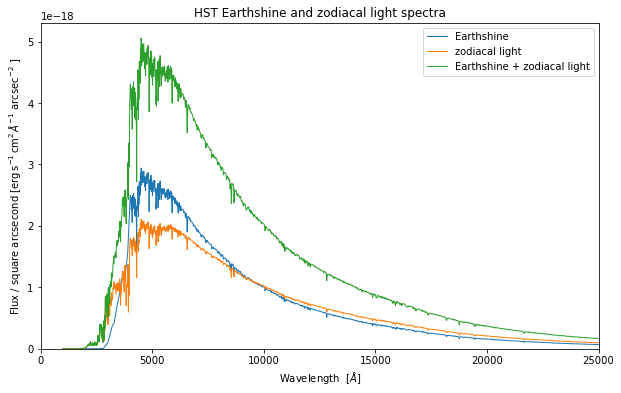

In [4]:
MyBackground = Background()

#
# Visualize the Earthshine + zodiacal light spectra. Note that _all_ of this code is only
# to plot the spectra and that this is absolutely not a required step in using the ETC...
#
fig = plt.figure(figsize=(10,6))
ax = plt.subplot(111)
ax.plot(
    MyBackground.earthshine_wavelengths,
    MyBackground.earthshine_flam,
    lw=1,
    label="Earthshine",
)
ax.plot(
    MyBackground.zodi_wavelengths,
    MyBackground.zodi_flam,
    lw=1,
    label="zodiacal light",
)
# Since these two spectra have the same wavelength grid, we can simply add them together
# to get the total Earthshine + zodiacal light spectrum. If th|eir wavelength grids are
# different, we can use interpolation (e.g., from `scipy`) to make them the same.
ax.plot(
    MyBackground.earthshine_wavelengths,
    (MyBackground.earthshine_flam + MyBackground.zodi_flam),
    lw=1,
    label="Earthshine + zodiacal light",
)
ax.set_xlabel(r"Wavelength  " +r'[$\AA$]')
ax.set_ylabel('Flux / square arcsecond ' + r'[$\rm erg\,s^{-1}\,cm^2\,$'  + r'$\AA^{-1}$ arcsec$^{-2}$ ]' )
ax.legend()
ax.set_xlim(0, 25000)
ax.set_ylim(bottom=0)

plt.title('HST Earthshine and zodiacal light spectra')


## Step 3) Simulate the source

In general, the creation of any `Source` object has three steps:

- Determining the type of the source (i.e., a point source, an extended source like a
  diffuse nebula, a galaxy, etc.)
- Describing the physical properties of the source, such as its spectrum (including any
  emission/absorption lines), the surface brightness profile of an extended source or
  galaxy, its redshift, distance, etc. Not all of these parameters need to be specified
  depending on your source.
- (Optional) Renormalizing the source spectrum. There are many normalization schemes
  available (e.g., normalize to an AB magnitude within a passband, normalize to a total
  luminosity and distance). Note that these normalizations can be applied at any time
  (e.g., can be before or after the addition of spectral lines).

---

Currently, for the UVMOS-ETC only point sources are supported.  Point sources are treated as Gaussian profiles with a FWHM equal to that of the telescope

However, a variety of spectra may be used.  This includes blackbody spectra and spectra from the Pickles library

EX) To select a blackbody spectrum
```python 
MySource.generate_bb(8000 * u.K, redshift=0.06)
```

EX) To select a pickles spectrum
```python 
spectral_class = 'ukwg5v'
MySource.use_pickles_spectrum(spectral_class)

```



### Choose an input spectrum


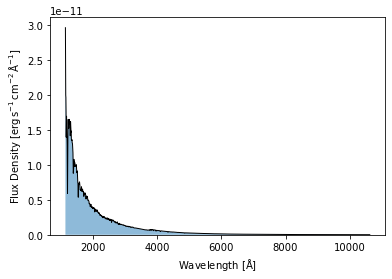

In [5]:
#
# Create point source
#
MySource = PointSource()
#
# Approximate the star as a blackbody with a temperature of 8000 K. By default, the
# spectral radiance of the blackbody (erg/s/cm^2/A/sr) is normalized to a star of 1 solar
# radius at 1 kpc distance to get the flux density in erg/s/cm^2/A (this can be changed
# via the `radius` and `dist` parameters).
# Note that only the temperature is required below, but some others are shown for
# illustration.
#

# Blackbody
# MySource.generate_bb(20000 * u.K)

# Pickles Spectrum
spectral_class = 'b0v'
MySource.use_pickles_spectrum(spectral_class)


# Power Law
# waves = np.arange(100,500,0.5)*u.nm
# ref_wave = 100 *u.nm
# MySource.generate_power_law(ref_wave, waves, 3)



#
# Optional: Renormalize the spectrum so it has a bolometric AB magnitude
# Note that bolometric AB magnitudes assume perfect telescope detector response over the
# whole spectrum. Please read the docstring for this function for more details.
#
MySource.norm_to_AB_mag(10)


#
# Optional: Add emission or absorption line
#
# MySource.add_emission_line(center=200*u.nm, fwhm=1*u.nm, peak=5e-11 )
# MySource.add_absorption_line(center=200*u.nm, fwhm=2*u.nm, dip=2e-19 )
# MySource.add_absorption_line(center=250*u.nm, fwhm=2*u.nm, dip=2e-19 )


#
# Visualize the spectrum
#
MySource.show_spectrum()


## Step 4) Do spectroscopy

Now that the telescope, sky backgroud, and source have been specified we are ready to begin spectroscopy.


In [6]:
#
# Create Spectroscopy object
#
MySpec = UVMOS_Spectroscopy(MyTelescope, MySource, MyBackground)

- By default, the spectral range of is set to be $150$nm to $300$nm.  This may be changed by setting `MySpec.min_wave` or `MySpec.max_wave` to some number with a wavelength unit in angstroms. For example:
```python
MySpec.min_wave = (150 * u.nm).to(u.AA)
MySpec.max_wave = (300 * u.nm).to(u.AA)
```

In order to do slit spectroscopy, a slit must be chosen.  
- By default, a slit with a width of $0.214"$ and height of $1"$ is used.

EX) Change the slit width and / or height
```python
MySpec.specify_slit(slit_width = 0.15 * u.arcsec, slit_height = 0.5 * u.arcsec   )
```


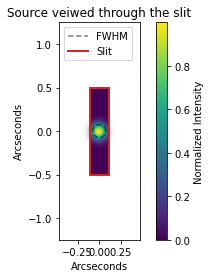

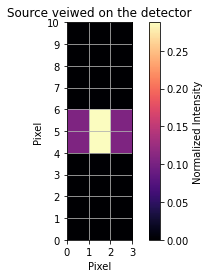

In [7]:
#
# Specify the slit
#
MySpec.specify_slit()


# 
# Optional: Show the source as viewed through the slit
#
MySpec.show_slit()

#
# Optional: Show a single image of the slit on the detector
#
MySpec.show_source_pix_weights()

- By default, the extraction box is set to a width of 1 pixel along the wavelength axis, and extends along the entire spatial axis.  The extraction box may be changed by passing the desired values to calculate CASTOR spectra functions. 
For example
```python 
MySpec.calc_source_CASTORSpectrum(extraction_width=2, extraction_lowerlim=4, extraction_upperlim = 7)
```


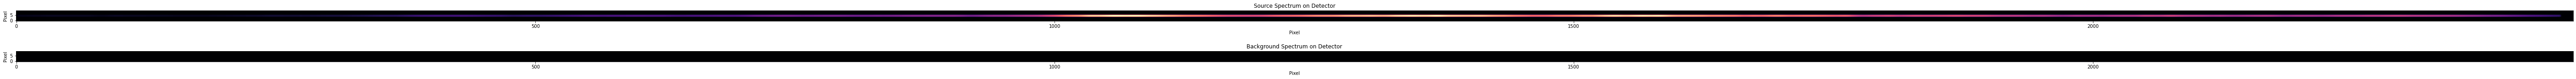

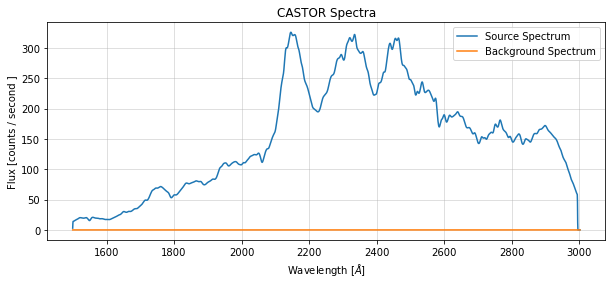

In [8]:
MySpec.calc_source_CASTORSpectrum(extraction_width=1, extraction_lowerlim=4, extraction_upperlim = 7)
MySpec.calc_background_CASTORSpectrum(extraction_width=1, extraction_lowerlim=4, extraction_upperlim = 7)

#
# Optional: Visualize the source and background spectra on the detector
#
plt.figure(figsize=(100,3))

ax1 = plt.subplot(211)
plt.imshow(MySpec.source_detector,origin='lower',cmap='magma',aspect='auto')
plt.title('Source Spectrum on Detector')
plt.xlabel('Pixel')
plt.ylabel('Pixel')
ax1.set_aspect('equal')


ax2 = plt.subplot(212, sharex=ax1, sharey=ax1)
plt.imshow(MySpec.background_detector*MySpec.source_extracted_numpixs,origin='lower',cmap='magma',aspect='auto', vmin=min(MySpec.source_detector.flatten()), vmax=max(MySpec.source_detector.flatten()))
plt.title('Background Spectrum on Detector')
plt.xlabel('Pixel')
plt.ylabel('Pixel')
ax2.set_aspect('equal')


#
# Optional: Visualize the source and background 
#
plt.figure(figsize=(10,4))
ax = plt.subplot(111)
plt.plot(MySpec.waves_CASTORSpectrum, MySpec.source_CASTORSpectrum,'-',label='Source Spectrum')

plt.plot(MySpec.waves_CASTORSpectrum, MySpec.background_CASTORSpectrum*MySpec.source_extracted_numpixs,'-',label='Background Spectrum')

plt.title('CASTOR Spectra')
plt.xlabel('Wavelength '+r'[$\AA$]')
plt.ylabel('Flux [counts / second ]')
plt.grid(alpha=0.5)
plt.legend()

In [9]:
MySpec.showResolvingPower()

FileNotFoundError: [Errno 2] No such file or directory: 'dispersion_resolution2.dat'

**Determine exposure times or signal-to-noise ratios**

In [ ]:
t = 100 # seconds
wave = 2000 # angstroms
snr = MySpec.calc_snr_from_t(t, wave)
print('After an exposure time of {:.3f} seconds a SNR of {:.3f} is reached at a wavelength of {} angstroms'.format(t,snr, wave))

In [ ]:
snr = 100  
wave = 2000 # angstroms
t = MySpec.calc_t_from_snr(snr, wave)
print('An exposure time of {:.3g} seconds is required to reach a SNR of {:.3f} at a wavelength of {} angstroms'.format(t,snr, wave))